---
title: Second Year Scholarship Data Visualization
show-code: false
format: 
    html: 
        embed-resources: true
        toc: true

---

In [7]:


import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import altair as alt
import folium

# Introduction: 



idea: a few sample descriptions to give context

In [8]:




# Step 1: Load your data
df = pd.read_csv("data/security_incidents.csv")

# Group by country for different categories (Nationals, Internationals, and Incidents)
nationals = df.groupby('Country')['Total nationals'].sum().reset_index(name="total_nationals")
internationals = df.groupby('Country')['Total internationals'].sum().reset_index(name="total_internationals")
incidents_by_country = df.groupby('Country').size().reset_index(name='incident_count')

# Load GeoJSON data for world countries using GeoPandas
geo_data = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Merge the datasets with the GeoDataFrame
geo_data = geo_data.merge(nationals, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(internationals, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(incidents_by_country, left_on="ADMIN", right_on="Country", how="left")



In [9]:

df_clean_location = df.dropna(subset=["Latitude", "Longitude"]).sample(200)
m = folium.Map(location=[14.07092855, 103.099916], zoom_start=5)

for index, row in df_clean_location.iterrows():
    # Extract relevant columns from the dataframe
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    description = row["Details"]  # You can adjust the description field if needed

    # Create a marker for each row
    folium.Marker(
        location=[latitude, longitude],
        popup=folium.Popup(description, max_width=300),
        tooltip=f"Incident ID: {row['Incident ID']} - {row['Country']}"
    ).add_to(m)
m.save("description_samples.html")


## National vs. International

In [10]:

# Create a choropleth map for Nationals, Internationals, and Incident
fig = go.Figure()

# Add choropleth for Nationals
fig.add_trace(go.Choropleth(
    z=geo_data['total_nationals'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='RdYlGn_r',
    colorbar_title="Nationals Affected",
    showscale=True,
    name="Nationals"
))

# Add choropleth for Internationals
fig.add_trace(go.Choropleth(
    z=geo_data['total_internationals'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='YlOrRd',
    colorbar_title="Internationals Affected",
    showscale=True,
    name="Internationals"
))

# Add choropleth for Incidents
fig.add_trace(go.Choropleth(
    z=geo_data['incident_count'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='BuGn',
    colorbar_title="Incidents Count",
    showscale=True,
    name="Incidents"
))

# Update layout to add dropdown and other configurations
fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
    ),
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [{'visible': [True, False, False]}, {'title': 'Nationals Affected'}],
                    'label': 'Nationals',
                    'method': 'update'
                },
                {
                    'args': [{'visible': [False, True, False]}, {'title': 'Internationals Affected'}],
                    'label': 'Internationals',
                    'method': 'update'
                },
                {
                    'args': [{'visible': [False, False, True]}, {'title': 'Incidents Count'}],
                    'label': 'Incidents',
                    'method': 'update'
                }
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1,
            'yanchor': 'top'
        }
    ],
    title="Incidents by Country"
)

fig.write_html("choropleth_map_with_dropdown.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("choropleth_map_with_dropdown.html", width=800, height=600)


We can see from above that mainly nationals are targetted, and a majority of incidents take place across Northern Africa and the Middle East. This is most likely due to the distribution of nationals vs. international aid workers stationed across the countries, with national aid workers being in much higher numbers. 

## Means of Attack

In [11]:


unique_values = df['Means of attack'].unique()
means_of_attack = df.groupby(['Country', 'Means of attack']).size().unstack(fill_value=0)

geo_data = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

for incident in unique_values:
    # Ensure the column name is consistent (spaces replaced with underscores and lowercased)
    incident_column = f'{incident.replace(" ", "_").lower()}_count'
    
    # Check if the incident type is present in the incident_counts DataFrame
    if incident in means_of_attack.columns:
        # Add the incident counts from the incident_counts DataFrame
        geo_data = geo_data.merge(
            means_of_attack[incident], left_on="ADMIN", right_index=True, how="left"
        ).rename(columns={incident: incident_column})
    else:
        # If the incident type is not in the incident_counts DataFrame, fill with 0
        geo_data[incident_column] = 0
# Create a choropleth map for Nationals, Internationals, and Incident
fig = go.Figure()

# Add choropleth for each incident type
for incident in unique_values:
    # Update the z values and title dynamically for each incident
    # Calculate the total value for the column
    total_value = geo_data[f'{incident.replace(" ", "_").lower()}_count'].sum()
    
    # Calculate the percentage for each country
    geo_data[f'{incident}_percentage'] = (geo_data[f'{incident.replace(" ", "_").lower()}_count'] / total_value) * 100
    
    fig.add_trace(go.Choropleth(
        z=geo_data[f'{incident.replace(" ", "_").lower()}_count'],  # Assuming you have these fields in your geo_data
        hoverinfo='location+z',
        locations=geo_data['ADMIN'],  # Country names should be in the 'ADMIN' field
        locationmode='country names',
        colorscale='Viridis',  # You can change the color scale for each incident type if you like
        colorbar_title=f"{incident} Count",
        showscale=True,
        name=incident,
        text=geo_data[f'{incident}_percentage'].apply(lambda x: f"{x:.2f}%")
    ))

# Update layout to add dropdown and other configurations
fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
    ),
    updatemenus=[
        {
            'buttons': [
                # Create a button for each incident type to switch between
                *[
                    {
                        'args': [{'visible': [i == idx for i in range(len(unique_values))]}, {'title': f'{incident} Count'}],
                        'label': incident,
                        'method': 'update'
                    }
                    for idx, incident in enumerate(unique_values)
                ]
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1,
            'yanchor': 'top'
        }
    ],
    title="Incidents by Country"
)

fig.write_html("choropleth_map_with_dropdown2.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("choropleth_map_with_dropdown2.html", width=800, height=600)


We look at the means of attack above across all countries that have incidents. Aid organizations often struggle with reporting (as this is not their first priority), so many of the attacks are of unknown means. 

## Organization

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'df' is your DataFrame with the necessary columns

# Prepare the cumulative sum DataFrame
df_cumulative = df[["UN", "INGO", "ICRC", "NRCS and IFRC", "NNGO", "Other", "Total affected", "Total killed"]].copy()

# Calculate cumulative sum for each column
df_cumulative['Cumulative UN'] = df_cumulative['UN'].cumsum()
df_cumulative['Cumulative INGO'] = df_cumulative['INGO'].cumsum()
df_cumulative['Cumulative ICRC'] = df_cumulative['ICRC'].cumsum()
df_cumulative['Cumulative NRCS and IFRC'] = df_cumulative['NRCS and IFRC'].cumsum()
df_cumulative['Cumulative NNGO'] = df_cumulative['NNGO'].cumsum()
df_cumulative['Cumulative Other'] = df_cumulative['Other'].cumsum()
df_cumulative['Cumulative Total affected'] = df_cumulative['Total affected'].cumsum()
df_cumulative['Cumulative Total killed'] = df_cumulative['Total killed'].cumsum()

# Create first figure (Total Affected)
fig_affected = go.Figure()

# Function to add traces for cumulative sum of Total affected
def add_trace_and_slope_affected(column, color, label):
    slope = (df_cumulative[column].iloc[-1] - df_cumulative[column].iloc[0]) / (len(df_cumulative) - 1)
    fig_affected.add_trace(go.Scatter(
        x=df_cumulative.index,
        y=df_cumulative[column],
        mode='lines',
        name=label,
        line=dict(color=color),
        hovertemplate='<b>%{text}</b><br>' +
                      'Value: %{y}<br>' +
                      'Overall Slope: %{customdata:.2f}',
        text=[label] * len(df_cumulative),
        customdata=[slope] * len(df_cumulative)
    ))

# Add traces for 'Total affected' plot
add_trace_and_slope_affected('Cumulative UN', 'blue', 'Cumulative UN')
add_trace_and_slope_affected('Cumulative INGO', 'orange', 'Cumulative INGO')
add_trace_and_slope_affected('Cumulative ICRC', 'red', 'Cumulative ICRC')
add_trace_and_slope_affected('Cumulative NRCS and IFRC', 'green', 'Cumulative NRCS and IFRC')
add_trace_and_slope_affected('Cumulative NNGO', 'pink', 'Cumulative NNGO')
add_trace_and_slope_affected('Cumulative Other', 'purple', 'Cumulative Other')
add_trace_and_slope_affected('Cumulative Total affected', 'magenta', 'Cumulative Total affected')

# Create second figure (Total Killed)
fig_killed = go.Figure()

# Function to add traces for cumulative sum of Total killed
def add_trace_and_slope_killed(column, color, label):
    slope = (df_cumulative[column].iloc[-1] - df_cumulative[column].iloc[0]) / (len(df_cumulative) - 1)
    fig_killed.add_trace(go.Scatter(
        x=df_cumulative.index,
        y=df_cumulative[column],
        mode='lines',
        name=label,
        line=dict(color=color),
        hovertemplate='<b>%{text}</b><br>' +
                      'Value: %{y}<br>' +
                      'Overall Slope: %{customdata:.2f}',
        text=[label] * len(df_cumulative),
        customdata=[slope] * len(df_cumulative)
    ))

# Add traces for 'Total killed' plot
add_trace_and_slope_killed('Cumulative UN', 'blue', 'Cumulative UN (Killed)')
add_trace_and_slope_killed('Cumulative INGO', 'orange', 'Cumulative INGO (Killed)')
add_trace_and_slope_killed('Cumulative ICRC', 'red', 'Cumulative ICRC (Killed)')
add_trace_and_slope_killed('Cumulative NRCS and IFRC', 'green', 'Cumulative NRCS and IFRC (Killed)')
add_trace_and_slope_killed('Cumulative NNGO', 'pink', 'Cumulative NNGO (Killed)')
add_trace_and_slope_killed('Cumulative Other', 'purple', 'Cumulative Other (Killed)')
add_trace_and_slope_killed('Cumulative Total killed', 'magenta', 'Cumulative Total killed')

# Update layout for titles and labels, and add dropdown for switching between the figures
fig_affected.update_layout(
    title='Cumulative Sum of UN and Total Affected',
    xaxis_title='Index',
    yaxis_title='Cumulative Sum',
    hovermode='closest',
    template='plotly_dark',  # Optional: Choose your theme
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"visible": True}],
                    "label": "Show Total Affected",
                    "method": "relayout"
                },
                {
                    "args": [None, {"visible": False}],
                    "label": "Show Total Killed",
                    "method": "relayout"
                }
            ],
            "direction": "down",
            "showactive": True,
            "active": 0,
            "x": 0.17,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top"
        }
    ]
)

fig_killed.update_layout(
    title='Cumulative Sum of UN and Total Killed',
    xaxis_title='Index',
    yaxis_title='Cumulative Sum',
    hovermode='closest',
    template='plotly_dark',  # Optional: Choose your theme
    updatemenus=[
        {
            "buttons": [
                {
                    "args": [None, {"visible": False}],
                    "label": "Show Total Affected",
                    "method": "relayout"
                },
                {
                    "args": [None, {"visible": True}],
                    "label": "Show Total Killed",
                    "method": "relayout"
                }
            ],
            "direction": "down",
            "showactive": True,
            "active": 1,
            "x": 0.17,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top"
        }
    ]
)

# Show both figures
fig_affected.write_html("chloropleth_total_affected.html")
fig_killed.write_html("cumulative_total_killed.html")

from IPython.display import IFrame

# Display both saved files directly in Jupyter Notebook
IFrame("cumulative_total_affected.html", width=800, height=600)
IFrame("cumulative_total_killed.html", width=800, height=600)


# Gender Distribution of Incidents

In [13]:


females = df.groupby('Country')['Gender Male'].sum().reset_index(name="male_total")
males = df.groupby('Country')['Gender Female'].sum().reset_index(name="female_total")

# Load GeoJSON data for world countries using GeoPandas
geo_data = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Merge the datasets with the GeoDataFrame
geo_data = geo_data.merge(females, left_on="ADMIN", right_on="Country", how="left")
geo_data = geo_data.merge(males, left_on="ADMIN", right_on="Country", how="left")

# Create a choropleth map for Nationals, Internationals, and Incident
fig = go.Figure()

# Add choropleth for Nationals
fig.add_trace(go.Choropleth(
    z=geo_data['male_total'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='RdYlGn_r',
    colorbar_title="Total Males",
    showscale=True,
    name="Males"
))

# Add choropleth for Internationals
fig.add_trace(go.Choropleth(
    z=geo_data['female_total'],
    hoverinfo='location+z',
    locations=geo_data['ADMIN'],
    locationmode='country names',
    colorscale='YlOrRd',
    colorbar_title="Total Females",
    showscale=True,
    name="Females"
))

# Update layout to add dropdown and other configurations
fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
    ),
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [{'visible': [True, False, False]}, {'title': 'Males Affected'}],
                    'label': 'Males',
                    'method': 'update'
                },
                {
                    'args': [{'visible': [False, True, False]}, {'title': 'Females Affected'}],
                    'label': 'Females',
                    'method': 'update'
                }
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0,
            'xanchor': 'left',
            'y': 1,
            'yanchor': 'top'
        }
    ],
    title="Gender Distribution"
)

fig.write_html("choropleth_map_with_dropdown3.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("choropleth_map_with_dropdown3.html", width=800, height=600)

/var/folders/8n/rfnmqbtd0tvdljpw_xbt64jh0000gn/T/ipykernel_53200/1354683842.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



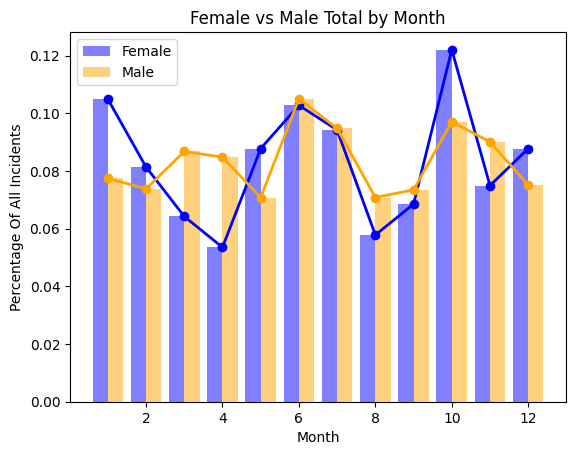

In [14]:


import matplotlib.pyplot as plt

df_clean = df.dropna()
df_clean['Date'] = pd.to_datetime(df_clean['Year'].astype(str) + '-' + df_clean['Month'].astype(int).astype(str) + '-01', format='%Y-%m-%d')
df_clean.head()

male = df_clean.groupby('Month')['Gender Male'].sum().reset_index(name="total_male")
female = df_clean.groupby('Month')['Gender Female'].sum().reset_index(name="total_female")

plt.bar(female["Month"] - 0.2, female["total_female"] / female["total_female"].sum(), width=0.4, label="Female", color='blue', align='center', alpha = .5)  # Female bars
plt.bar(male["Month"] + 0.2, male["total_male"] / male["total_male"].sum(), width=0.4, label="Male", color='orange', align='center', alpha = 0.5)  # Male bars
plt.plot(female["Month"], female["total_female"] / female["total_female"].sum(), color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(male["Month"], male["total_male"] / male["total_male"].sum(), color='orange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Percentage Of All Incidents')
plt.title('Female vs Male Total by Month')
plt.legend()
plt.show()





/var/folders/8n/rfnmqbtd0tvdljpw_xbt64jh0000gn/T/ipykernel_53200/2897098690.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



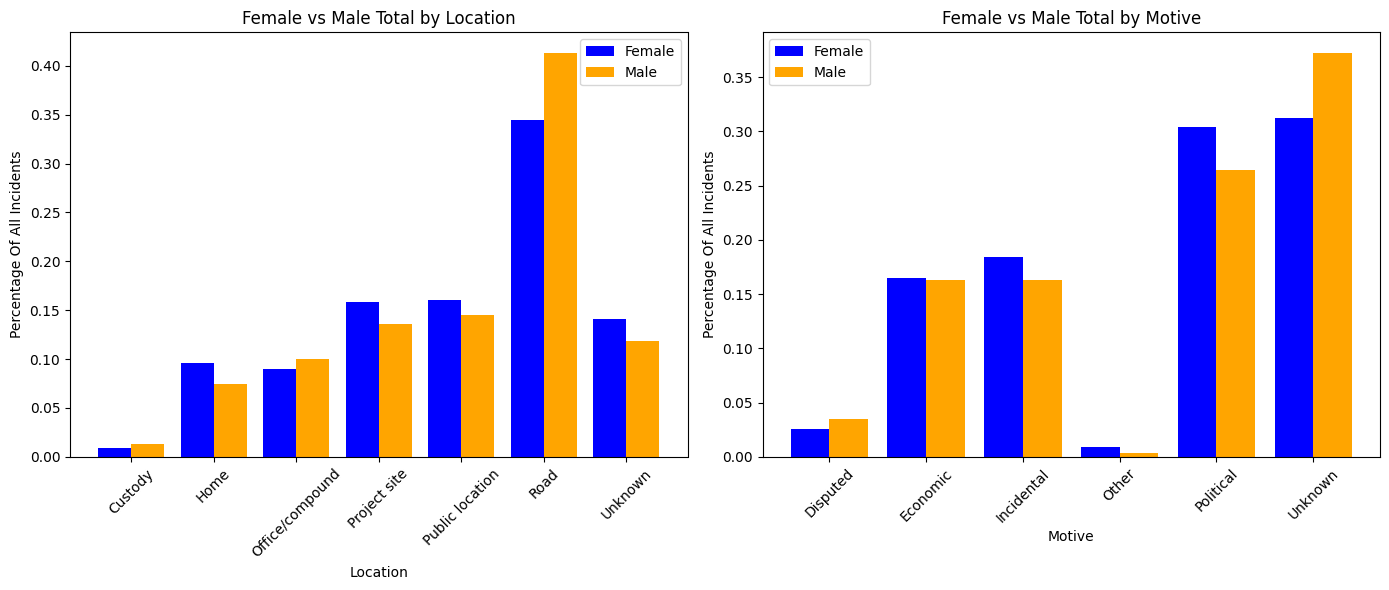

In [15]:


df_clean = df.dropna()
df_clean['Date'] = pd.to_datetime(df_clean['Year'].astype(str) + '-' + df_clean['Month'].astype(int).astype(str) + '-01', format='%Y-%m-%d')
df_clean.head()

import matplotlib.pyplot as plt

# Male and female data by Location
male_location = df_clean.groupby('Location')['Gender Male'].sum().reset_index(name="total_male")
female_location = df_clean.groupby('Location')['Gender Female'].sum().reset_index(name="total_female")
locations = female_location["Location"]
x_location = range(len(locations))  # Create an index for each location

# Male and female data by Motive
male_motive = df_clean.groupby('Motive')['Gender Male'].sum().reset_index(name="total_male")
female_motive = df_clean.groupby('Motive')['Gender Female'].sum().reset_index(name="total_female")
motives = female_motive["Motive"]
x_motive = range(len(motives))  # Create an index for each motive

# Create a figure with 2 subplots (2 facets)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot (Location)
ax1.bar([i - 0.2 for i in x_location], female_location["total_female"] / female_location["total_female"].sum(), width=0.4, label="Female", color='blue', align='center')
ax1.bar([i + 0.2 for i in x_location], male_location["total_male"] / male_location["total_male"].sum(), width=0.4, label="Male", color='orange', align='center')

ax1.set_xlabel('Location')
ax1.set_ylabel('Percentage Of All Incidents')
ax1.set_title('Female vs Male Total by Location')
ax1.set_xticks([i for i in x_location])
ax1.set_xticklabels(locations, rotation=45)
ax1.legend()

# Second subplot (Motive)
ax2.bar([i - 0.2 for i in x_motive], female_motive["total_female"] / female_motive["total_female"].sum(), width=0.4, label="Female", color='blue', align='center')
ax2.bar([i + 0.2 for i in x_motive], male_motive["total_male"] / male_motive["total_male"].sum(), width=0.4, label="Male", color='orange', align='center')

ax2.set_xlabel('Motive')
ax2.set_ylabel('Percentage Of All Incidents')
ax2.set_title('Female vs Male Total by Motive')
ax2.set_xticks([i for i in x_motive])
ax2.set_xticklabels(motives, rotation=45)
ax2.legend()

# Adjust layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()


add hypothesis test

ideas: 

radio button - men/women
dropdown - variable

In [16]:


import altair as alt

organizations = ["UN","INGO","ICRC","NRCS and IFRC","NNGO","Other"]
columns = ["Nationals killed","Nationals wounded","Nationals kidnapped","Total nationals","Internationals killed","Internationals wounded","Internationals kidnapped","Total internationals","Total killed","Total wounded","Total kidnapped","Total affected"]

dropdown = alt.binding_select(options=columns, name='Y-axis column ')
selection = alt.selection_point(
    fields=['selected_column'],
    bind=dropdown
)
# # Color changing marks
# rating_radio = alt.binding_radio(options=ratings, name="Rating")
# rating_select = alt.selection_point(fields=['Gender'], bind=gend)


# highlight_ratings = base.add_params(
#     rating_select
# ).encode(
#     color=rating_color
# ).properties(title="Radio Button Highlighting")
# Create a radio button for gender selection

radio = alt.binding_radio(options=["Gender Male", "Gender Female"], name="Gender Affected")
select_radio = alt.selection_point(
    fields=['selected_gender'],
    bind=radio
)


rating_color = (
    alt.when(select_radio)
    .then(alt.Color("MPAA_Rating:N").legend(None))
    .otherwise(alt.value("lightgray"))
)

# Melt the dataframe to have a long-form structure (for dynamic column selection)
df_clean_folded = df_clean.melt(id_vars=['Year', 'Gender Male', 'Gender Female'], value_vars=columns, var_name='selected_column', value_name='value')

# Create the base chart with x-axis and y-axis dynamically set
chart = alt.Chart(df_clean_folded.sample(5000)).mark_circle().encode(
    x='Year:O',  # Ensure year is categorical for clarity
    y=alt.Y('value:Q', title=''),
    color='selected_column:N'
).add_params(
    selection,
    select_radio
).transform_filter(
    selection
).transform_filter(
    alt.datum['Gender Male'] == (select_radio == 'Gender Male')  # Filter based on selected gender
)

chart



alt.Chart(...)

In [17]:


import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler


categorical_columns = [ 
    "Motive",  "Location", "Actor type", "Attack context"]
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True).drop(columns=["Means of attack", "Nationals killed","Nationals wounded","Nationals kidnapped","Total nationals","Internationals killed","Internationals wounded","Internationals kidnapped","Total internationals","Actor name", "District","Country Code", "Details", "Verified", "Source","Country", "Region", "City", "Incident ID"])
df_encoded.replace("Unknown", 0, inplace=True)
scaler = StandardScaler()
df_encoded = pd.DataFrame(scaler.fit_transform(df_encoded), columns = df_encoded.columns)
correlation_matrix = df_encoded.corr()

fig = px.imshow(correlation_matrix,
                labels=dict(x="Features", y="Features", color="Correlation"),
                color_continuous_scale='RdBu_r', 
                zmin=-1, zmax=1)

# Customize the layout to ensure all labels are readable
fig.update_layout(
    title="Correlation Matrix",
    xaxis=dict(tickmode='array', tickvals=list(range(len(correlation_matrix.columns))), ticktext=correlation_matrix.columns),
    yaxis=dict(tickmode='array', tickvals=list(range(len(correlation_matrix.columns))), ticktext=correlation_matrix.columns),
    width=1200,  # You can further adjust the size of the plot
    height=1200,
    margin=dict(l=-0, r=0, b=0, t=100)  # Adjust margins to fit labels
)

fig.write_html("corr_matrix.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("corr_matrix.html", width=1000, height=1000)

In [18]:


correlation_matrix2 = df_encoded.iloc[:,3:16].corr()
fig2 = px.imshow(correlation_matrix2,
                labels=dict(x="Features", y="Features", color="Correlation"),
                color_continuous_scale='RdBu_r', 
                zmin=-1, zmax=1)

# Customize the layout to ensure all labels are readable
fig2.update_layout(
    title="Correlation Matrix",
    xaxis=dict(tickmode='array', tickvals=list(range(len(correlation_matrix2.columns))), ticktext=correlation_matrix2.columns),
    yaxis=dict(tickmode='array', tickvals=list(range(len(correlation_matrix2.columns))), ticktext=correlation_matrix2.columns),
    width=1000,  # You can further adjust the size of the plot
    height=1000,
    margin=dict(l=100, r=100, b=0, t=100)  # Adjust margins to fit labels
)

fig2.write_html("corr_matrix2.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("corr_matrix2.html", width=1000, height=1000)

In [19]:
sum_columns = ["UN", "INGO", "ICRC", "NRCS and IFRC", "NNGO", "Other"]
total_affected_by_org = df.groupby(sum_columns)["Total affected"].sum()  # Summing the organization columns for 'Total affected'
total_killed_by_org = df.groupby(sum_columns)["Total killed"].sum()# Create a choropleth map for Nationals, Internationals, and Incident
fig = go.Figure()

# Add choropleth for Nationals
fig.add_trace(go.Bar(
    x = total_affected_by_org.index,
    y = total_affected_by_org,
    name="Affected", 
    visible = True
))

fig.add_trace(go.Bar(
    x = total_killed_by_org.index,
    y = total_killed_by_org,
    name="Killed", 
    visible = False
))


fig.update_layout(
    updatemenus=[
        {
            'buttons': [
                {
                    'args': [{'visible': [True, False]}, {'title': 'Total Affected'}],
                    'label': 'Affected',
                    'method': 'update'
                },
                {
                    'args': [{'visible': [False, True]}, {'title': 'Total Killed'}],
                    'label': 'Killed',
                    'method': 'update'
                },
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.05,
            'xanchor': 'left',
            'y': 1.15,
            'yanchor': 'top'
        }
    ],
    title="Incidents by Organization",
    barmode='group',  # Group bars by organization
    xaxis_title="Organizations",
    yaxis_title="Count"
)


fig.write_html("bar.html")

from IPython.display import IFrame

# Display the saved file directly in Jupyter Notebook
IFrame("bar.html", width=800, height=600)
